In [1]:
%reload_ext autoreload
%autoreload 2

try:
    import pdcleaner
except ModuleNotFoundError:
    print("extended path variable")
    import sys
    sys.path.append('..')
    import pdcleaner

extended path variable


In [2]:
import random

import numpy as np
import pandas as pd


np.random.seed(seed=0)
random.seed(0)

In [3]:
def compute_sphere_volume(diameter):
        return np.pi / 6  * (diameter**3)

def generate_bounded_normal(n, distribution_info, precision=None):
    if "min" not in distribution_info:
        distribution_info["min"] = np.NINF
    if "max" not in distribution_info:
        distribution_info["max"] = np.inf

    normal_values = np.random.normal(distribution_info["mu"], distribution_info["sigma"], n)
    bounded_values = np.clip(normal_values, distribution_info["min"], distribution_info["max"])

    if precision:
        return bounded_values.round(precision)
    return bounded_values
    
def generate_with_expr(base_series, expr, sigma_noise=None, precision=None):
    values = base_series.apply(expr)
    if sigma_noise:
        noise = np.random.normal(0, sigma_noise, len(values))
        values = values + noise
    if precision:
        return values.round(precision)
    return values
    
def generate_category(category_name, n_samples, price_info, diameter_info, density, volume_noise=None):
    """
    n_samples, price_info, diameter_info, weight_info
    """
    
    df = pd.DataFrame( [[category_name, np.nan, np.nan, np.nan]] * n_samples,
            columns=["category", "price(euro)", "diameter(cm)", "weight(kg)"])
    
    df["price(euro)"] = generate_bounded_normal(n_samples, price_info, 2)
    df["diameter(cm)"] = generate_bounded_normal(n_samples, diameter_info, 1)
    volme_series = generate_with_expr(df["diameter(cm)"], compute_sphere_volume, sigma_noise=volume_noise)
    df["weight(kg)"] = (1e-3 * density * volme_series).round(3).clip(lower=0.)
    
    return df

#diameter in cm, weight in kg

In [4]:
#pomme
n = 100
price_info = {"sigma":1.5, "mu":3., "min":0.49, "max":7.99}
diameter_info = {"sigma":1, "mu":7, "min":1., "max":12}
mv = 0.84 #masse volumique en g/cm3
df_pomme = generate_category("pomme", n, price_info, diameter_info, mv, volume_noise=15)

#cerise
n = 100
price_info = {"sigma":2.5, "mu":9., "min":4.99, "max":14.99}
diameter_info = {"sigma":0.7, "mu":2.5, "min":1., "max":4.}
mv = 0.64
df_cerise = generate_category("cerise", n, price_info, diameter_info, mv, volume_noise=1)

#navet
n = 30
price_info = {"sigma":1., "mu":2.2, "min":0.29, "max":4.99}
diameter_info = {"sigma":4., "mu":8., "min":4., "max":16.}
mv = 0.6
df_navet = generate_category("navet", n, price_info, diameter_info, mv, volume_noise=20)

In [5]:
n_samples = 100
all_data = pd.concat([df_pomme, df_cerise, df_navet])
data = all_data.sample(n=n_samples).reset_index(drop=True)
data

,category,price,diameter,weight
0,navet,1.82,13.4,0.760
1,pomme,2.53,6.5,0.095
2,pomme,2.96,6.9,0.153
3,pomme,2.23,6.3,0.112
4,pomme,3.18,8.9,0.304
...,...,...,...,...
95,pomme,1.53,8.9,0.290
96,pomme,2.05,5.9,0.070
97,cerise,11.85,2.1,0.003
98,pomme,0.49,7.1,0.157


In [6]:
data.category.value_counts()

pomme     49
cerise    36
navet     15
Name: category, dtype: int64

rajouter une colonne de donnée à distribution normale : teneur en pesticide en mg/kg

https://eur-lex.europa.eu/legal-content/FR/TXT/?uri=LEGISSUM%3Al21289

Int64Index([30, 9, 15, 74, 75, 38, 20, 41, 85, 22], dtype='int64')


array([<AxesSubplot:ylabel='data'>,
       <AxesSubplot:xlabel='Count', ylabel='data'>,
       <AxesSubplot:xlabel='Density', ylabel='data'>,
       <AxesSubplot:ylabel='data'>], dtype=object)

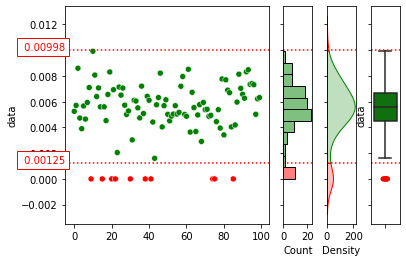

In [7]:
pesticide_info = {"sigma":0.0015, "mu":0.006}
data["pesticide_content(mg/kg)"] = generate_bounded_normal(data.shape[0], pesticide_info, precision=5)
#noisy bio products with 0 pesticides
random_indices = data.sample(10).index
print(random_indices)
data.loc[random_indices, "pesticide_content(mg/kg)"] = 0.

data["pesticide_content(mg/kg)"].cleaner.detect("iqr", threshold=1.5).plot()

In [8]:
def generate_varieties(category_series):
    dict_varieties = {
        "pomme" : ["golden", "granny"],
        "cerise" : ["amarelles", "bigarreaux"],
        "navet" : ["de Milan", "de Nancy"]
    }
    
    return category_series.apply(lambda x : random.choice(dict_varieties[x]))

data["variety"] =  generate_varieties(data.category)
data.variety.value_counts()

granny        26
golden        23
amarelles     19
bigarreaux    17
de Milan       8
de Nancy       7
Name: variety, dtype: int64

In [9]:
data.to_csv("data/clean_data.csv")